In [1]:
# statistics about attributes. Which attr. keys are there, which values?
# statistics about quality ratings -> quality depending on brand and other keywords
# how are guitars actually clustered by a CNN? E.g., ResNet-50 or CLIP feature vector?


In [2]:
from os.path import join, basename, splitext
from glob import glob
from DLBio.helpers import MyDataFrame, load_json
import json
from helpers import preprocess_image, get_bounding_box, show_crop, get_id, crop_to_content
from random import choice
import pandas as pd

In [3]:
# READ ATTRIBUTES:

def to_dict(items_:list, file_id:str):
    out = {'Name':file_id}
    for item in items_:
        item = item.replace('\n', '')
        split = item.split(': ')
        key = split[0]
        value = ': '.join(split[1:])
        out[key] = value

    return out

def get_id(x:str):
    return splitext(basename(x))[0]

def read_attributes(to_dict, get_id):
    folder = 'guitar_attributes'
    df_attrib = MyDataFrame()
    for filename in glob(join(folder, '*.txt')):
        with open(filename, 'r') as filehandle:
            text = filehandle.readlines()
    
        df_attrib.update(
        to_dict(text, get_id(filename)),
        add_missing_values=True, missing_val=""
    )
    return df_attrib.get_df()

df_attrib = read_attributes(to_dict, get_id)
df_attrib.head(5)


,Name,Farbe,Bauart,Korpusform,Saitenanzahl,Halskonstruktion,Bundanzahl,Mensur,Korpusmaterial,Decke,...,Regler,Bridge/Tremolo,Hardware,Lieferumfang,Produktionsland,Serien-Nr.,Saitenstärke ab Werk,Besonderheit(en),Gewicht,Pickup Middle
0,d-angelico-premier-dc-fr,Fiesta Red,Semi-Hollow Body,ES-Modell,6-saitig,eingeleimt,22,"25"" (635 mm)","Ahorn, laminiert","Ahorn, laminiert",...,"2x Volume, 2x Tone",Tune-O-Matic mit Stop Tailpiece,Chrom,Gigbag,Südkorea,,,,,
1,prs-custom-24-wood-library-10132905,Fire Red To Grey Black Fade,Solid Body,PRS-Style,6-saitig,eingeleimt,24,"25"" (635 mm)",Mahagoni,"Ahorn, geriegelt (Figured Maple)",...,"1x Volume, 1x Tone",PRS Patented Tremolo,Nickel,Koffer + Zubehörset,USA,0321334,.010 - .046,Wood Library,"3,43 kg",
2,danelectro-dc59csb-12-string-hollowbody,Cherry Sunburst,Semi-Hollow Body,sonstige,12-saitig,verschraubt,21,,Masonite (Holzfaser),,...,"2x Volume, 2x Tone",feste Brücke,Chrom,,Südkorea,,,,,
3,squier-classic-vibe-60s-jazzmaster-3ts,3-Tone Sunburst,Solid Body,Offset,6-saitig,verschraubt,21,"25,5"" (648 mm)",Pappel (Poplar),,...,"1x Volume, 1x Tone",6-Saddle Vintage-Style with Non-Locking Floati...,Nickel,,Indonesien,,.009 - .042,Mustang Bridge,,
4,squier-classic-vibe-60s-competition-mustang-cpo,Capri Orange with Dakota Red Stripes,Solid Body,Offset,6-saitig,verschraubt,21,"24"" (610 mm)",Pappel (Poplar),,...,"1x Volume, 1x Tone",Floating Bridge with Dynamic Vibrato Tailpiece,Nickel,,Indonesien,,.009 - .042,Limited Edtion,,


In [4]:
len(df_attrib["Halskonstruktion"].unique())

3

In [5]:
# READ REVIEWS

def review_statistic(reviews_:list):
    tmp_df = MyDataFrame()
    for review in reviews_:
        tmp_df.update({k:v for k,v in review.items() if isinstance(v, float)})

    return tmp_df.get_df().mean(0).round(1)
    

folder = 'guitar_reviews'
df_rev = MyDataFrame()
for filename in glob(join(folder, '*.json')):
    data = load_json(filename)
    tmp = {
        'Name':get_id(filename),
        'num_reviews':len(data)
        }
    
    if tmp['num_reviews'] > 0:
        tmp.update(review_statistic(data))

    df_rev.update(tmp,
        add_missing_values=True, missing_val=0.
    )
    
df_rev = df_rev.get_df()

In [6]:
df_rev[df_rev.num_reviews > 0].sort_values("num_reviews", ascending=False).head(30)

,Name,num_reviews,Gesamteindruck,Ausstattung,Qualität,Preis/Leistung
560,brian-may-special-ac,26,5.0,4.8,4.8,4.9
2581,epiphone-les-paul-standard-50s-vintage-sunburst,20,4.9,5.0,4.8,4.8
1173,epiphone-les-paul-standard-60s-iced-tea,20,4.9,4.9,4.8,4.8
552,epiphone-les-paul-standard-60s-ebony,20,4.9,5.0,4.8,4.8
2594,ibanez-gio-grg170dx-bkn,17,4.7,4.5,4.5,4.8
272,slick-sl-60-tv,13,4.7,4.4,4.5,5.0
2176,ibanez-gio-grg170dx-bkn-10083991,12,4.9,4.7,4.6,5.0
843,slick-sl-59-bk,11,4.9,4.2,4.5,5.0
1952,slick-sl-50-sg,11,4.9,4.5,4.5,5.0
2421,ibanez-gio-grg121dx-wnf,10,4.5,4.2,4.5,4.5


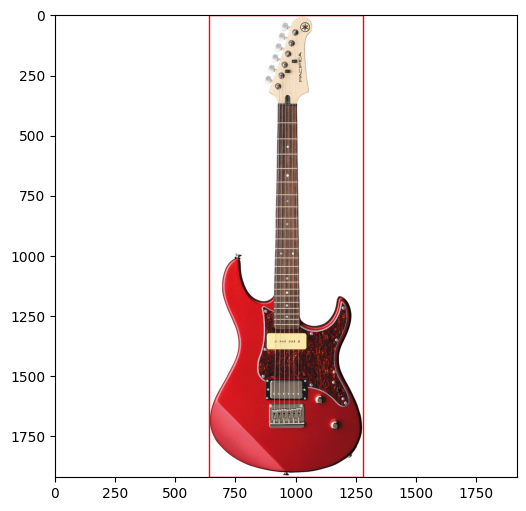

In [7]:

image_folder = 'guitar_images'
images_ = list(glob(join(image_folder, '*.jpg')))

image = preprocess_image(choice(images_), to_uint=True)
show_crop(image, **get_bounding_box(image))

In [9]:
df_size = MyDataFrame()
for image_path in glob(join(image_folder, '*.jpg')):
    image = preprocess_image(image_path, to_uint=True)
    tmp = get_bounding_box(image)
    tmp['Name'] = get_id(image_path)
    df_size.update(tmp)
    break

df_size = df_size.get_df()
df_size.head(10)
df_size['height'] = df_size['bottom'] - df_size['top']
df_size['width'] = df_size['right'] - df_size['left']
df_size['ratio'] = df_size['height'] / df_size['width']

#df_size.to_csv('image_sizes.csv')

df_size = pd.read_csv('image_sizes.csv')
#df_size['ratio'].mean(), df_size['ratio'].min(), df_size['ratio'].max(),

In [ ]:
image.shape

Text(0.5, 1.0, '(476, 164, 3)')

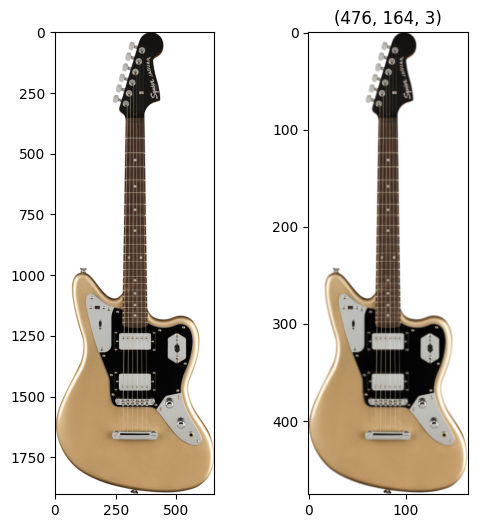

In [10]:
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt

import numpy as np
def get_index(image):
    h,w,_ = image.shape
    x = np.arange(5)

    z = (h*w)/((2*x)**2 + 0.00001)
    y = 256**2
    # roughly have the number of pixel 256*256
    index = np.argmin(np.abs(y-z))
    return x[index]


image_folder = 'guitar_images'
images_ = list(glob(join(image_folder, '*.jpg')))

image = preprocess_image(choice(images_), to_uint=True)
image = crop_to_content(image)

_, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].imshow(image)
downsampled = list(
    pyramid_gaussian(image, downscale=2,channel_axis=-1)
)[get_index(image)] 
ax[1].imshow(downsampled)
ax[1].set_title(downsampled.shape)

(-0.5, 147.5, 443.5, -0.5)

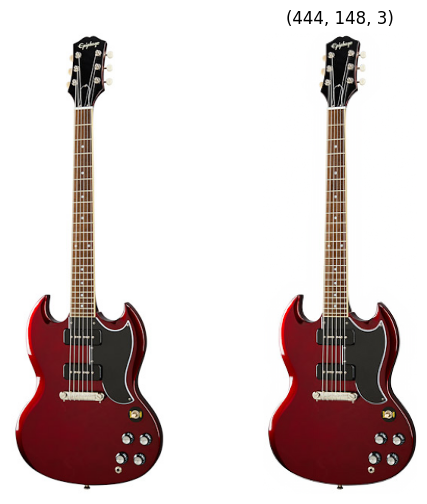

In [11]:
from skimage.transform import resize

image_folder = 'guitar_images'
images_ = list(glob(join(image_folder, '*.jpg')))

image_path = join(image_folder, 'epiphone-sg-special-p-90-sbu.jpg')

#image = preprocess_image(choice(images_), to_uint=True)
image = preprocess_image(image_path, to_uint=True)
image = crop_to_content(image, padding=4)

DESIRED_SHAPE = (3 * 148, 148)


_, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].imshow(image)
ax[0].axis('off')

downsampled = resize(
            image, DESIRED_SHAPE,
              order=2, anti_aliasing=True, mode='constant', cval=1
              )
ax[1].imshow(downsampled)
ax[0].axis('off')
ax[1].set_title(downsampled.shape)
ax[1].axis('off')
